# WiDS Datathon Workshop 2024
<img src="logos.png" style="height: 200px;" align="center"/>

Organizers: Sharut Gupta (MIT CSAIL), Jia He (Microsoft), and Arushi Jain (Microsoft).

Datathon: https://www.kaggle.com/competitions/widsdatathon2024-challenge2/overview

Datathon task: predict the duration of time it takes for patients to receive metastatic cancer diagnosis.

## Learning Goals:
* Exploratory data analysis
* Data pre-processing (encoding categorical variables, scaling, imputation)
* Fitting a simple model

# Setup & download the data

## Options for setting up compute environment:
* [Kaggle notebook](https://www.kaggle.com/c/widsdatathon2021/code) --> Click "New Notebook" to create a notebook. This notebook can be shared with others.
* Install python on your own machine (e.g. via [Anaconda](https://docs.anaconda.com/anaconda/install/)) --> This will install Jupyter notebook & Spyder IDE, which can be used for writing code.
* [Deepnote](https://deepnote.com/) notebook - good for collaboration/editing by multiple individuals, but cannot be used for running computationally intensive tasks.
* [Google Colab](colab.research.google.com)


## Download the data
You can download the data ("train.csv" and "test.csv") from the Kaggle competition (https://www.kaggle.com/competitions/widsdatathon2024-challenge2/data) directly onto your computer or if using Kaggle notebook, the data will be directly available in "/kaggle/input/widsdatathon2023/" directory.



## Load necessary libraries

In [ ]:
# !pip install statsmodels==0.13.5
!pip install lightgbm==3.3.5
!pip install colorama


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
# necessary libraries
import numpy as np  # numerical computation with arrays
import pandas as pd # library to manipulate datasets using dataframes
from colorama import Style, Fore
import math
import re
# Statistical libraries
from scipy.stats import norm 
from scipy import stats

# Load plotting libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.figsize":(8, 4), "figure.dpi":300}) #width=8, height=4

# Load sklearn libraries for machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import lightgbm as lgbm

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore") 

# Exploratory data analysis

* Use [Pandas](https://pandas.pydata.org/docs/) package to read and display data
* Explore the columns of the dataset (e.g. target and features)
* Explore patterns and trends in the data through data visualization

## Load the data
The data contains roughly 19k record dataset (split into training and test sets) representing patients and their characteristics, diagnosis and treatment information, geo demographic data.

In [ ]:
# Load the dataset using pandas
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
# Set column 'patient_id' as the index of rows
df_train = df_train.set_index('patient_id')
df_test = df_test.set_index('patient_id')

In [ ]:
# Print first couple of rows of the dataset
df_train.head()

,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,...,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
patient_id,,,,,,,,,,,,,,,,,,,,,
268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,C50912,...,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,C50412,...,49.30,72.87,77.40,77.43,75.83,72.64,58.36,39.68,39.71,33
277055,NaN,COMMERCIAL,CA,925,West,Pacific,59,F,NaN,1749,...,68.50,70.31,78.61,87.24,85.52,80.75,70.81,62.67,55.58,157
320055,Hispanic,MEDICAID,CA,900,West,Pacific,59,F,NaN,C50911,...,63.34,63.10,67.45,75.86,75.24,71.10,68.95,65.46,59.46,146
190386,NaN,COMMERCIAL,CA,934,West,Pacific,71,F,NaN,1748,...,59.45,60.24,64.77,69.81,70.13,68.10,65.38,60.72,54.08,286


## Compute basic properties of the dataset

In [ ]:
# How many rows and columns are in the dataset
print(f'{Style.BRIGHT}{Fore.YELLOW} SHAPE')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Train: {Fore.GREEN} {df_train.shape}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Test:  {Fore.GREEN} {df_test.shape}')

print(f'\n\n{Style.BRIGHT}{Fore.YELLOW} CONTAINS NULL VALUES?')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Train: {Fore.GREEN} {df_train.isnull().any().any()}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Test:  {Fore.GREEN} {df_test.isnull().any().any()}')

 SHAPE
 -> Train:  (13173, 151)
 -> Test:   (5646, 150)


 CONTAINS NULL VALUES?
 -> Train:  True
 -> Test:   True


In [ ]:
desc = pd.DataFrame(index = list(df_train))
desc['type'] = df_train.dtypes
desc['count'] = df_train.count()
desc['nunique'] = df_train.nunique()
desc['%unique'] = desc['nunique'] /len(df_train) * 100
desc['null'] = df_train.isnull().sum()
desc['%null'] = desc['null'] / len(df_train) * 100
desc = pd.concat([desc,df_train.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null'])

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
patient_zip3,int64,13173,751,5.701055,0,0.000000,568.530859,275.758485,100.00,330.00,557.00,832.00,995.00
patient_age,int64,13173,67,0.508616,0,0.000000,59.271313,13.218883,18.00,50.00,59.00,67.00,91.00
metastatic_diagnosis_period,int64,13173,366,2.778410,0,0.000000,96.515221,108.969873,0.00,3.00,44.00,181.00,365.00
population,float64,13173,751,5.701055,0,0.000000,20651.373928,13840.379638,635.55,9160.34,18952.78,30021.28,71374.13
density,float64,13173,747,5.670690,0,0.000000,1776.872376,3876.061897,0.92,163.15,700.34,1666.52,29851.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...
metastatic_cancer_diagnosis_code,object,13173,43,0.326425,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payer_type,object,11408,3,0.022774,1765,13.398618,NaN,NaN,NaN,NaN,NaN,NaN,NaN
patient_race,object,6516,5,0.037956,6657,50.535186,NaN,NaN,NaN,NaN,NaN,NaN,NaN
metastatic_first_novel_treatment,object,11,2,0.015183,13162,99.916496,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- High number of null values. What draws the most attention is 'bmi' which contains 69% of null data.


- Dataset with many columns, it may be possible to select features.


- Discrepant values in some attributes, such as 'home_value'.


- 11 categorical variables, 4 of which have a high cardinality (between 43 and 47 possible values)

In [ ]:
TARGET = 'metastatic_diagnosis_period'
NUMERIC_COLS = [f for f in df_train._get_numeric_data().columns if f!= TARGET]
CAT_COLS     = list(df_test.drop(NUMERIC_COLS, axis = 1))

> Numeric data distribution in training and test set

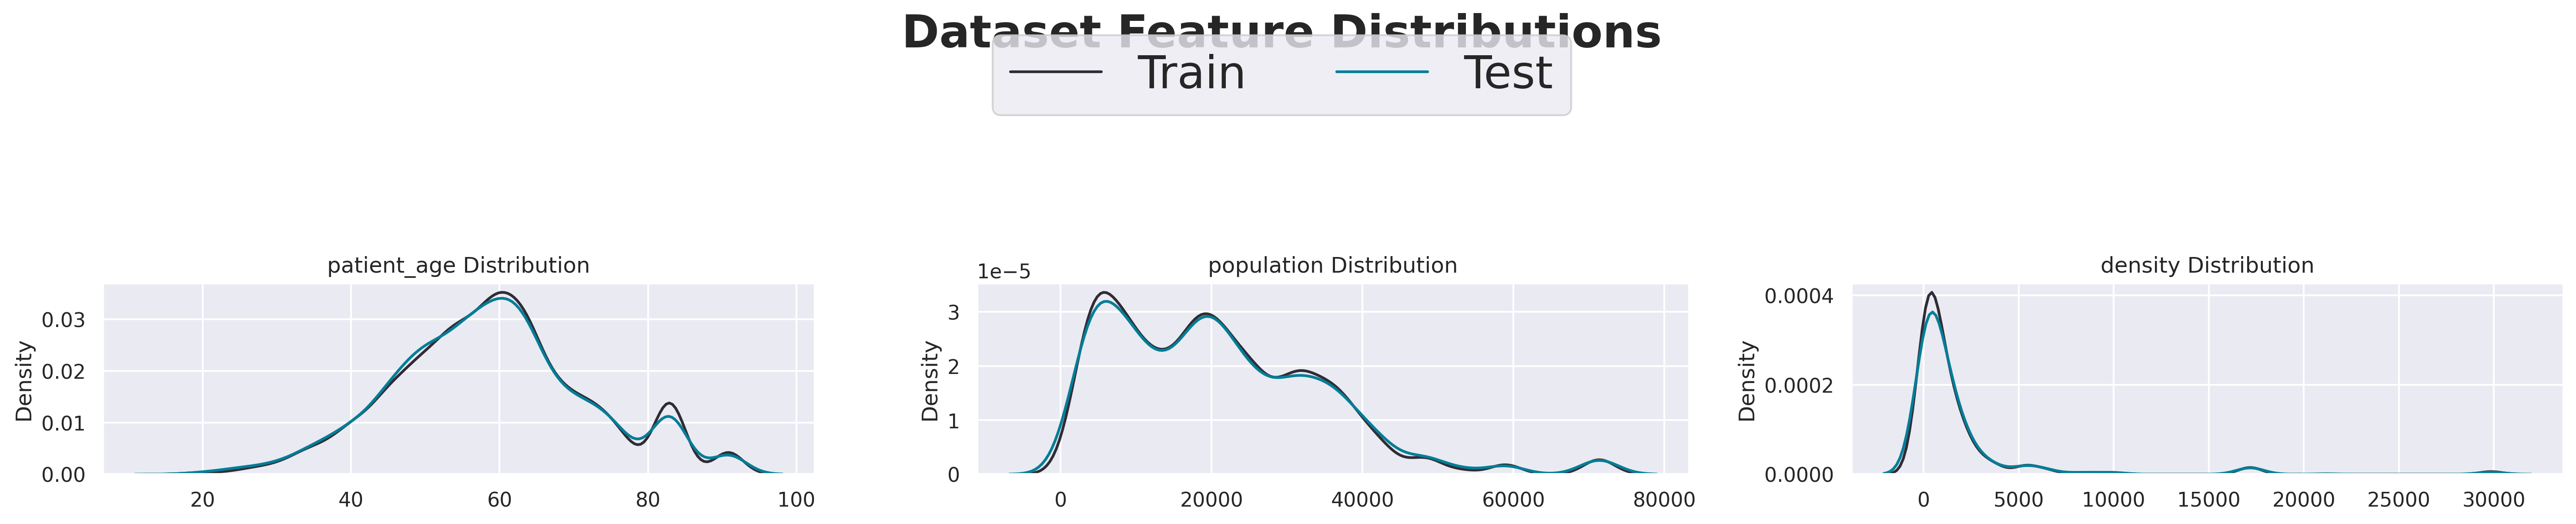

In [ ]:
def plot_numeric(selected_columns):
    # thanks @sergiosaharovskiy
    palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
               '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']
    features = df_test.columns
    n_bins = 50
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }

    columns = selected_columns
    n_cols = 3
    n_rows = math.ceil(len(columns)/n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
    ax = ax.flatten()

    for i, column in enumerate(columns):
        plot_axes = [ax[i]]
        sns.kdeplot(
            df_train[column], label='Train',
            ax=ax[i], color=palette[0]
        )

        sns.kdeplot(
            df_test[column], label='Test',
            ax=ax[i], color=palette[1]
        )

        # titles
        ax[i].set_title(f'{column} Distribution');
        ax[i].set_xlabel(None)

        # remove axes to show only one at the end
        plot_axes = [ax[i]]
        handles = []
        labels = []
        for plot_ax in plot_axes:
            handles += plot_ax.get_legend_handles_labels()[0]
            labels += plot_ax.get_legend_handles_labels()[1]
            plot_ax.legend().remove()

    for i in range(i+1, len(ax)):
        ax[i].axis('off')

    fig.suptitle(f'Dataset Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25, y=1.00)
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.00), fontsize=25, ncol=3)
    plt.tight_layout()

selected_columns = [NUMERIC_COLS[i] for i in (1, 3, 4)] 
plot_numeric(selected_columns)


- Numeric data distribution are similar in training and test data

> Histogram of Target -- Metastatic Diagnosis Period in Train Data

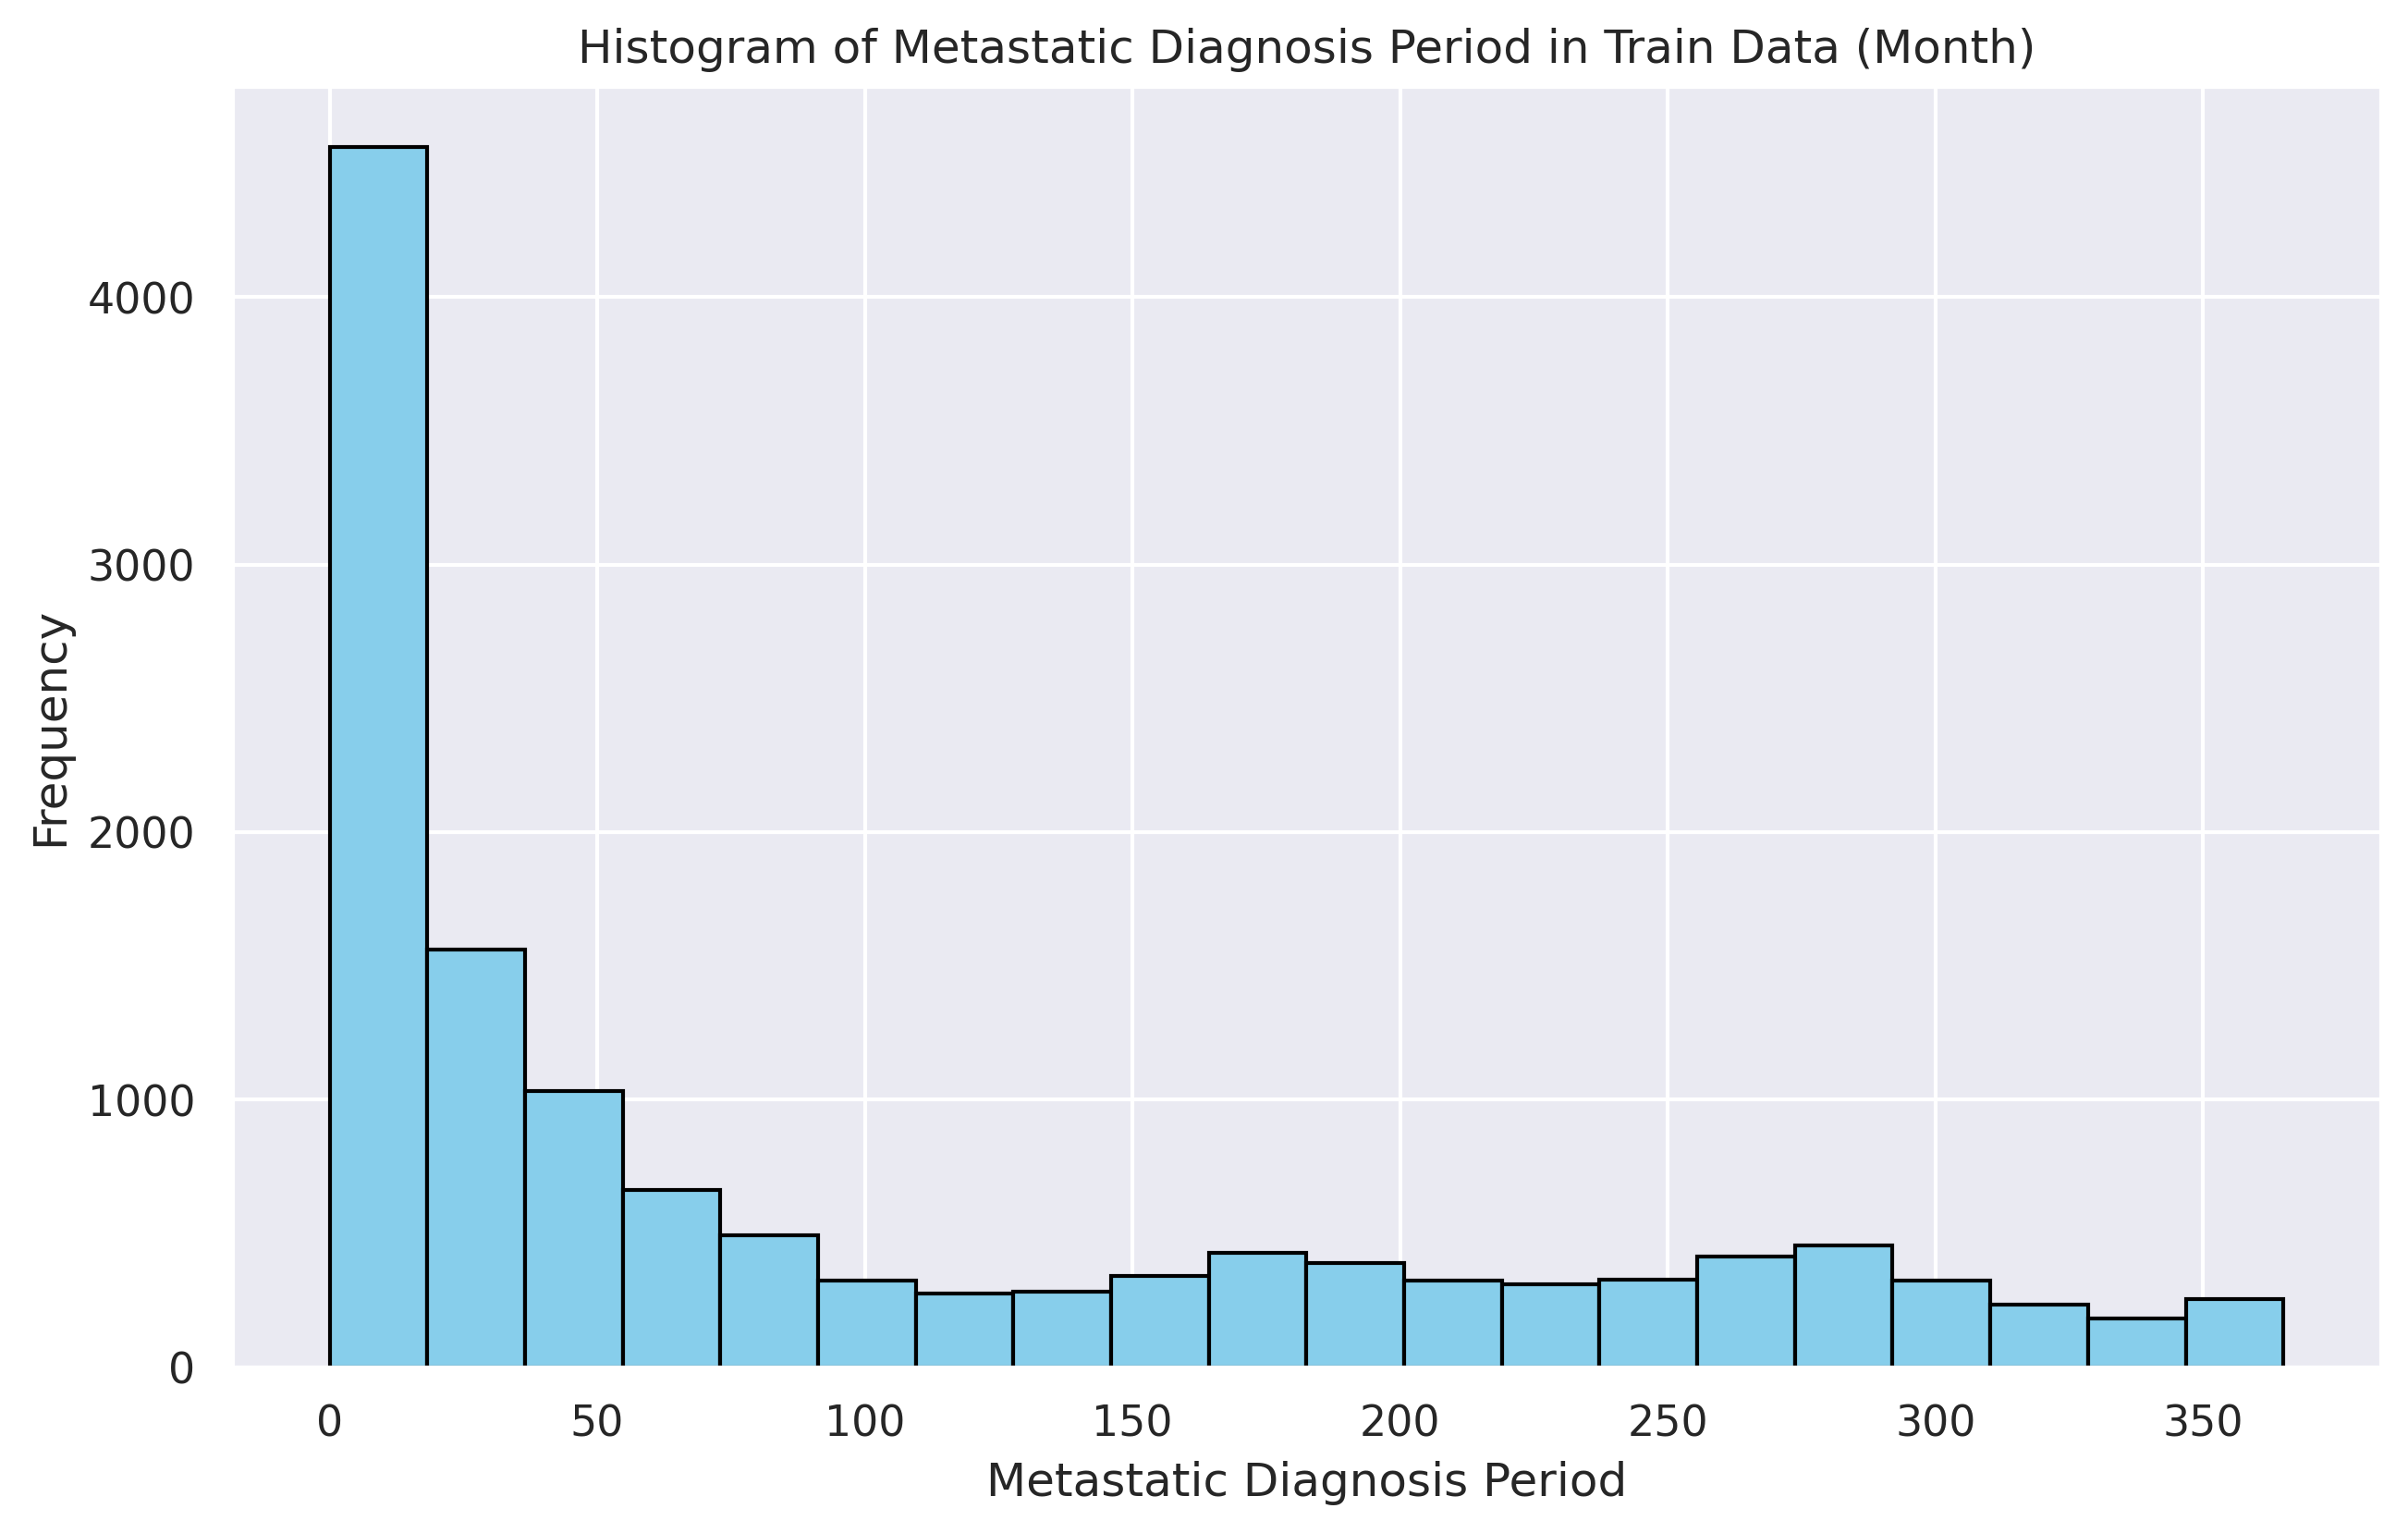

In [ ]:
# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(df_train['metastatic_diagnosis_period'], bins=20, color='skyblue', edgecolor='black')

plt.xlabel('Metastatic Diagnosis Period')
plt.ylabel('Frequency')
plt.title('Histogram of Metastatic Diagnosis Period in Train Data (Month)')
plt.grid(True)
plt.show()

- The distribution of the output variable approaches a Tweedie distribution.


> Selected feature distribution

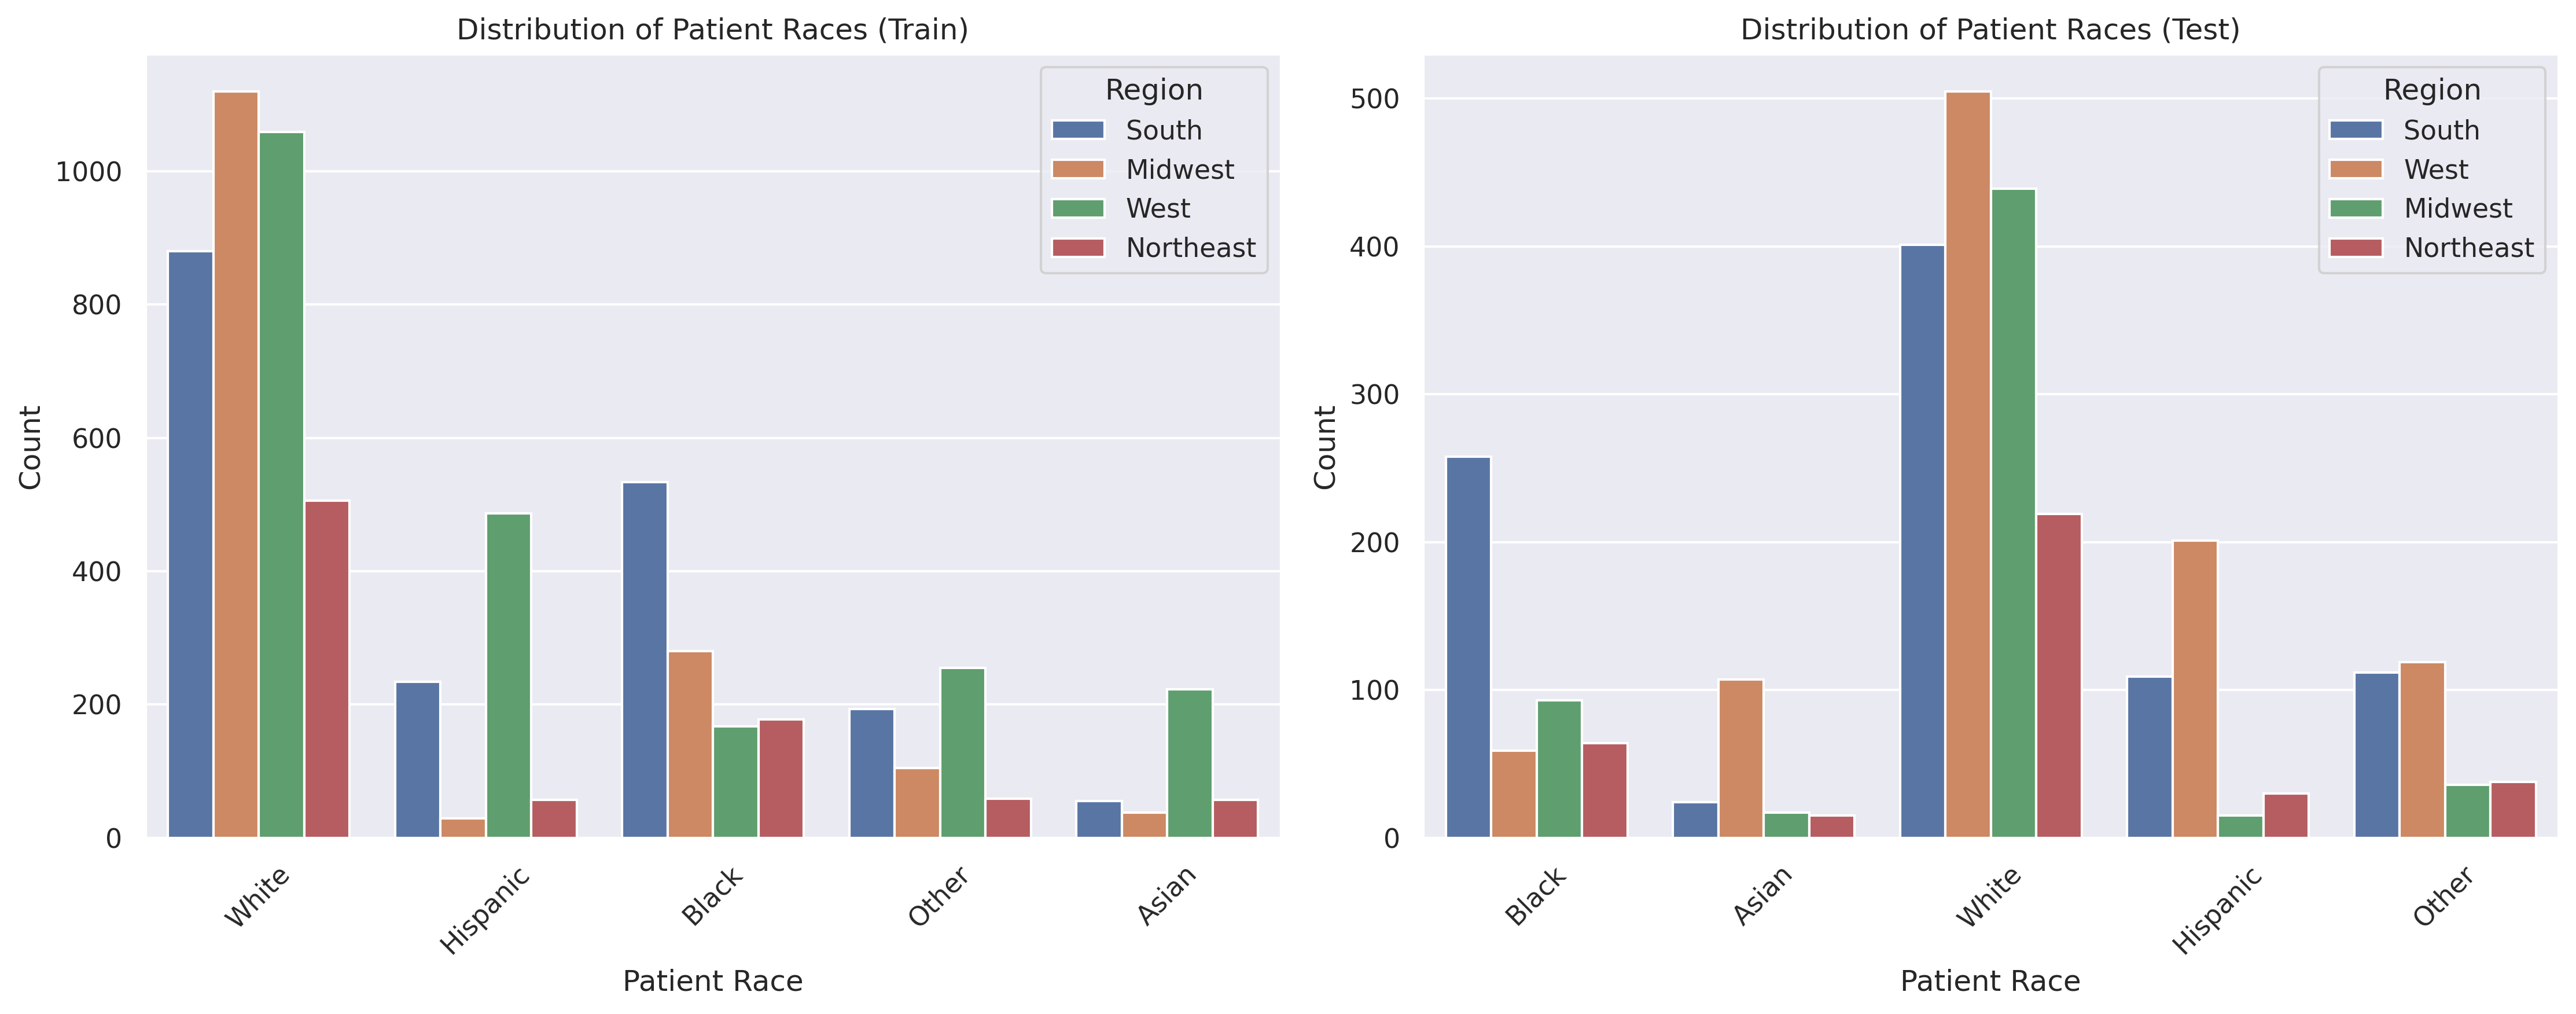

In [ ]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Assuming patient_race is a categorical variable
train_race_counts = df_train['patient_race'].value_counts()
test_race_counts = df_test['patient_race'].value_counts()

# Plotting the bar graph for train data
sns.countplot(data=df_train, x='patient_race', hue='Region', ax=axes[0])
axes[0].set_xlabel('Patient Race')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Patient Races (Train)')
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Plotting the bar graph for test data
sns.countplot(data=df_test, x='patient_race', hue='Region', ax=axes[1])
axes[1].set_xlabel('Patient Race')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Patient Races (Test)')
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

> Mean Metastatic Diagnosis Period by Patient Race

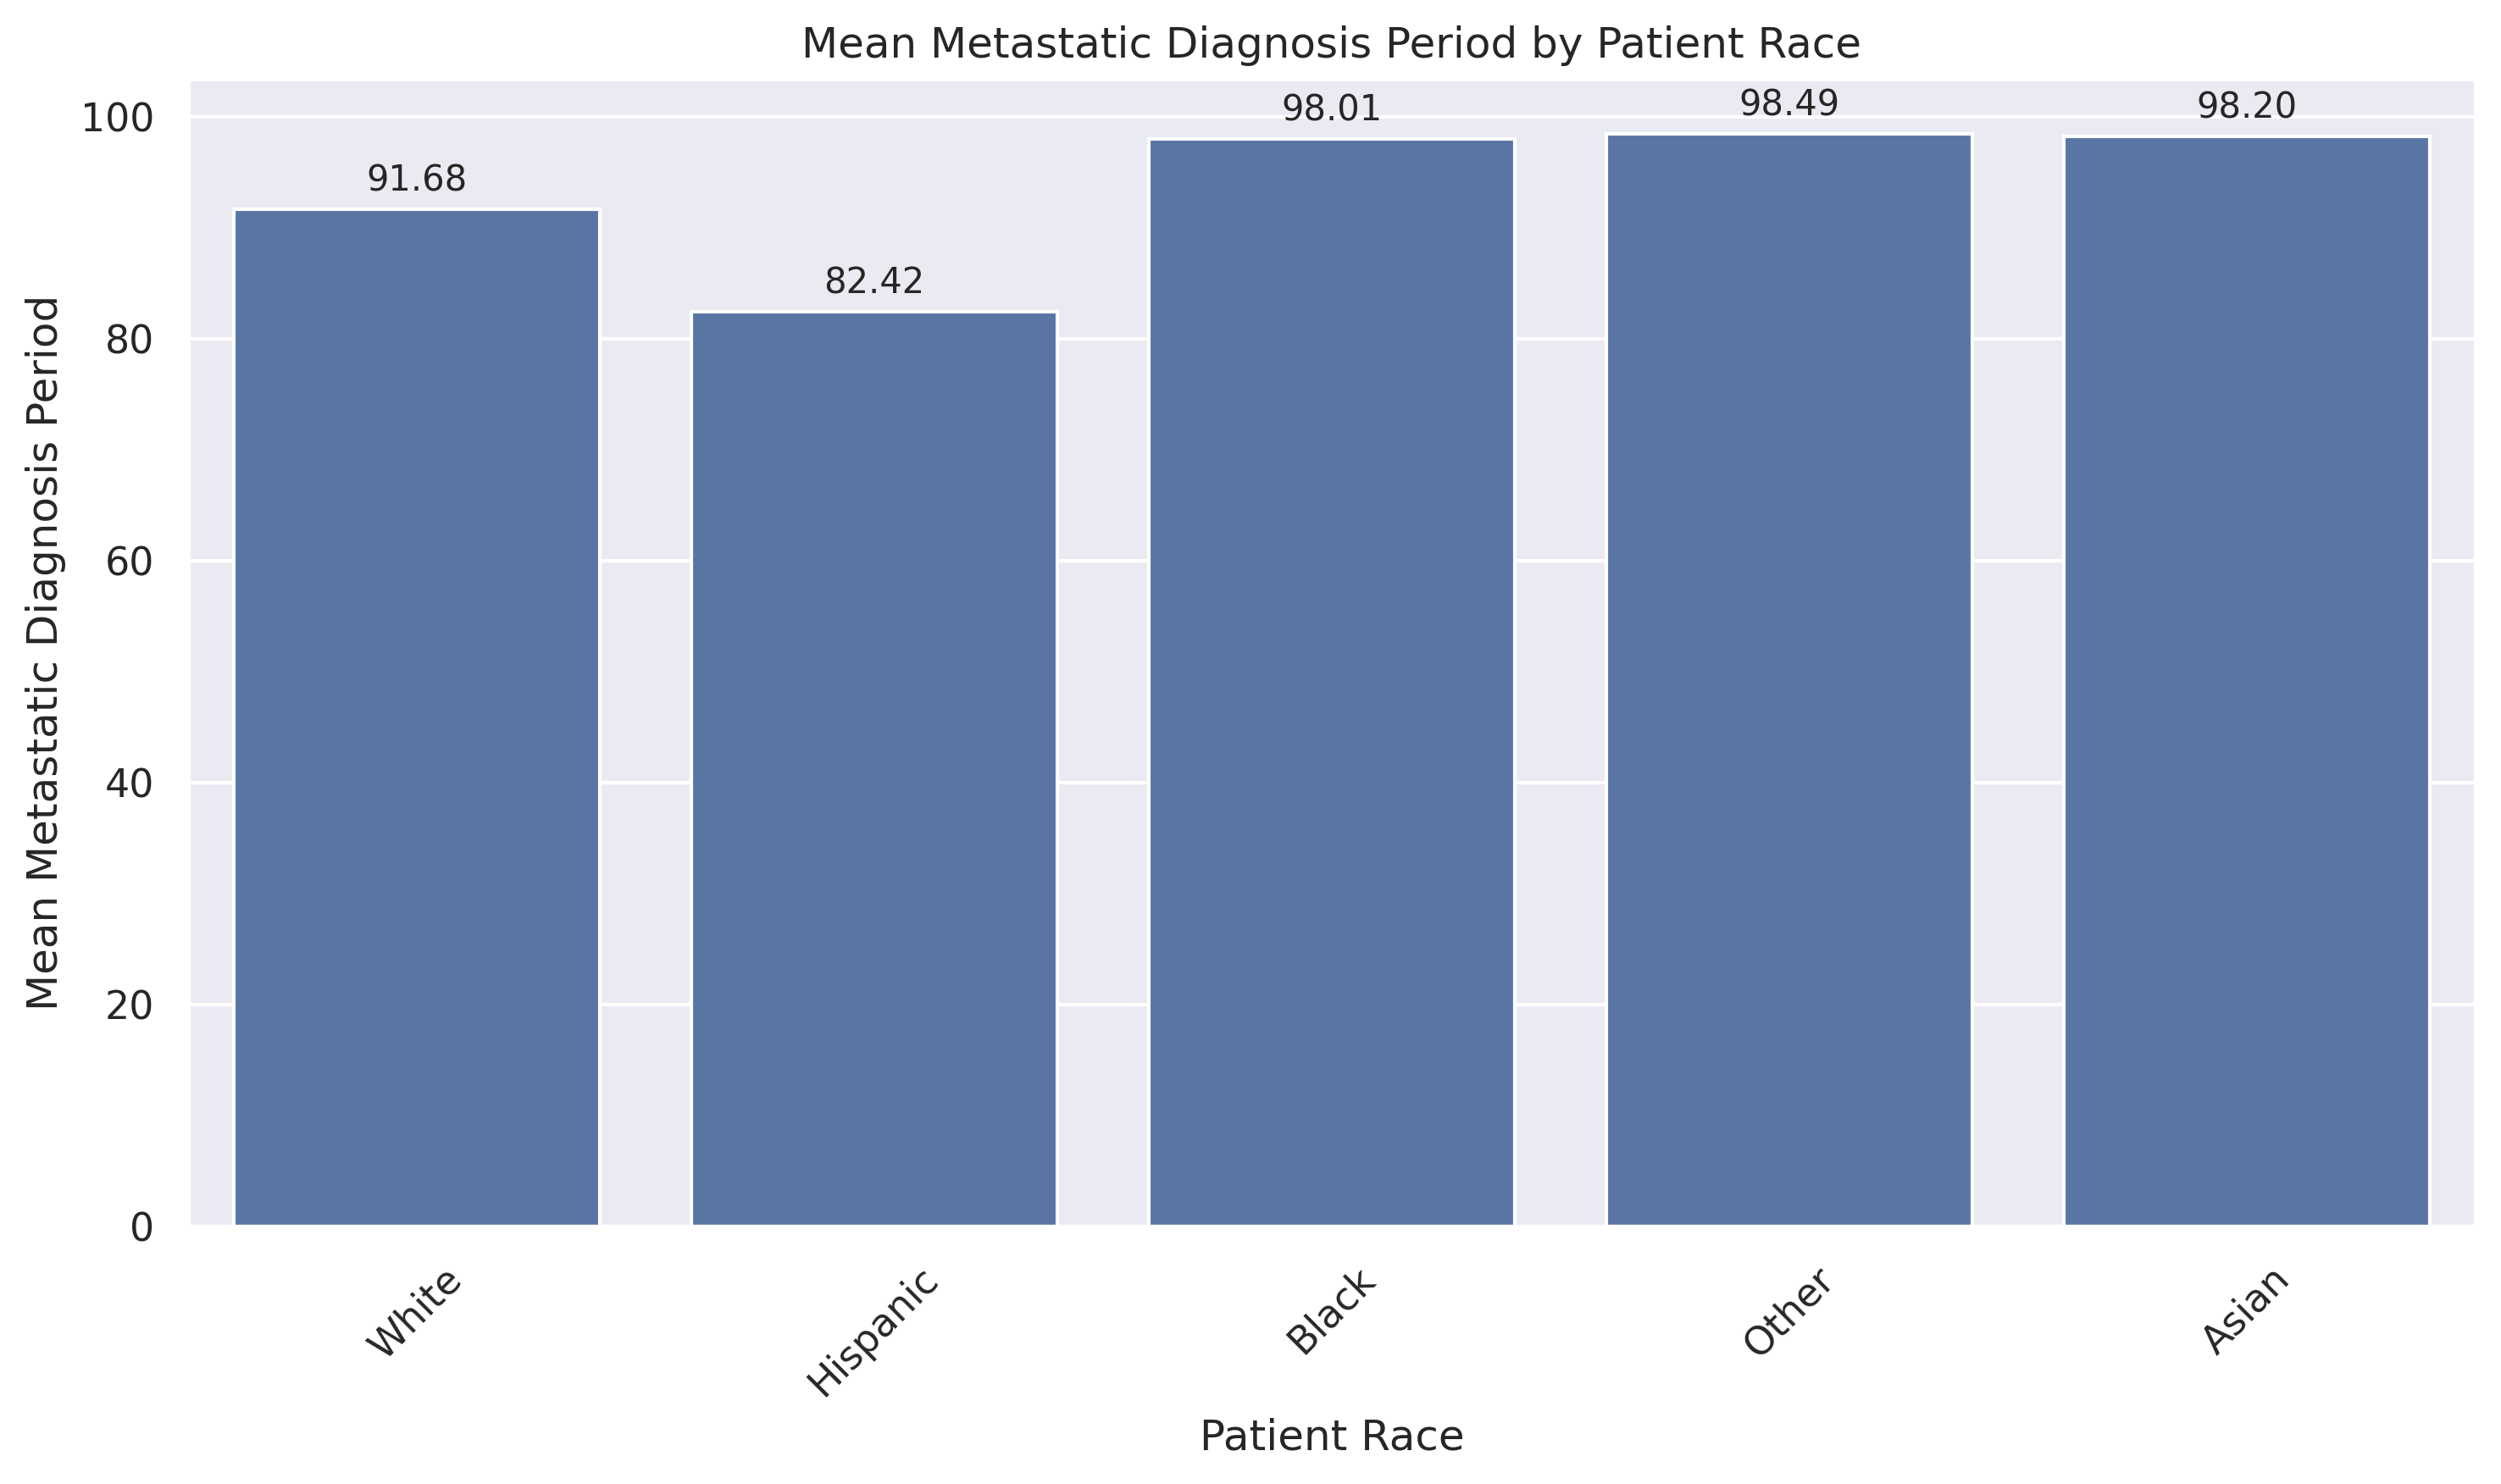

In [ ]:
# patient_race is a categorical variable and metastatic_diagnosis_period is numeric
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plotting the bar graph
ax = sns.barplot(data=df_train, x='patient_race', y='metastatic_diagnosis_period',  errorbar=None)  # ci=None disables error bars
plt.xlabel('Patient Race')
plt.ylabel('Mean Metastatic Diagnosis Period')
plt.title('Mean Metastatic Diagnosis Period by Patient Race')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Annotate each bar with its corresponding mean value
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'), 
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                 ha='center', va='center',
                 size=10, xytext=(0, 8),
                 textcoords='offset points')

plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

> Explore correlation between temperature and target feature

Correlation between temperature and target variable.


metastatic_diagnosis_period    1.000000
Average of May-15              0.029484
Average of Aug-16              0.024953
Average of Jul-13              0.023826
Average of Jun-14              0.021052
                                 ...   
Average of Apr-16             -0.001240
Average of Nov-15              0.000774
Average of Feb-18              0.000537
Average of Apr-14             -0.000391
Average of Mar-16              0.000292
Name: metastatic_diagnosis_period, Length: 73, dtype: float64

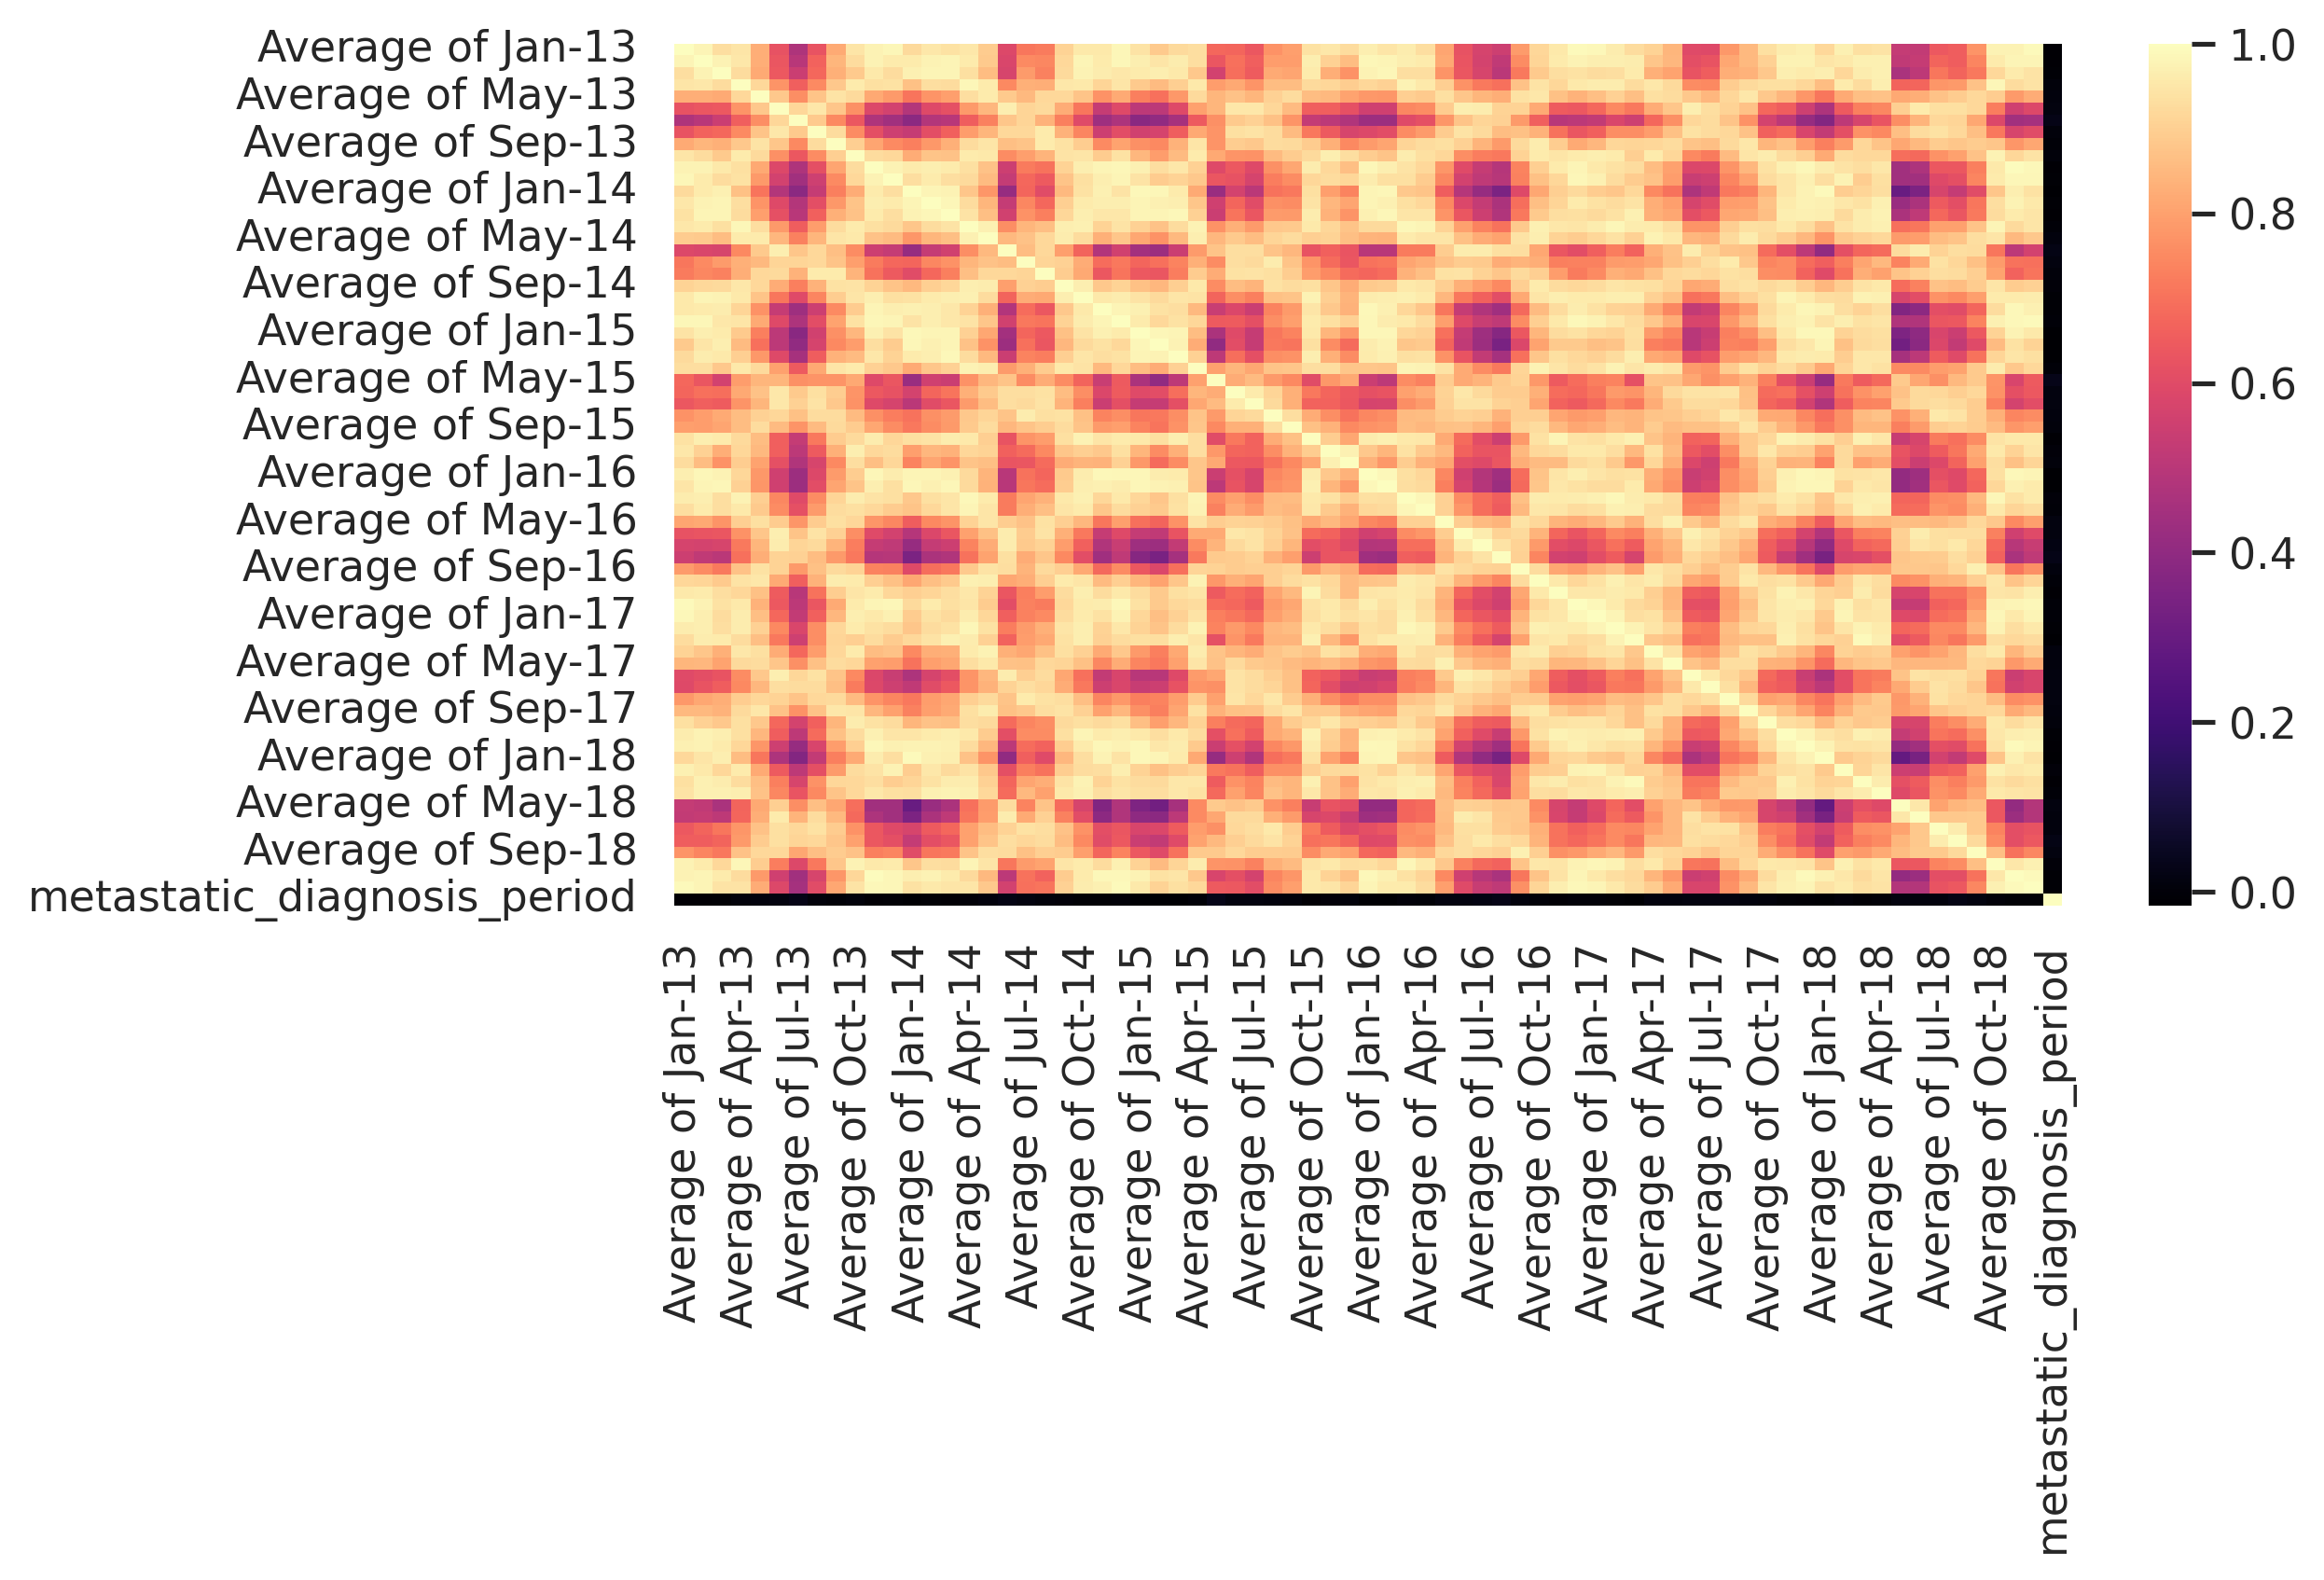

In [ ]:
# Explore correlations between temperature and the target variable
temperature_features = df_train.columns[-73:].values
df_corr = df_train[temperature_features].corr()
sns.heatmap(df_corr,cmap='magma')
# Sort features by their (absolute) correlation with the target variable.
print("Correlation between temperature and target variable.")
df_corr.sort_values(by='metastatic_diagnosis_period', key=abs, ascending=False)['metastatic_diagnosis_period']

- Temperature is weakly correlated with target variable.

# Pre-process the data
* Impute missingness
* Encode categorical features
* Feature selection
* Scale the values of the predictors

## Impute missing values
* Tool : Impute missing values using e.g. scikit-learn (https://scikit-learn.org/stable/modules/impute.html)
* Approaches:
    * Imputation based on mean/median/mode of the variable
    * Imputation based on k-nearest neighbors
    * Imputation based on regression imputation
* Considerations: To make a reasonable choice, analyze and understand the nature and extent of missing values in your data, evaluate and compare the strengths and weaknesses of different imputation methods. Additionally, you should avoid using a single imputation method for all variables and cases, and test and validate the imputation results.

> Missing imputation using mean/median/mode of the variable

In [ ]:
# Function to impute missing values in the dataset. 
def impute_df(df, imputation_dict):
    """
    Impute missing values in a pandas dataframe using specified imputation methods.

    Parameters:
        df (pandas.DataFrame): Dataframe with missing values to be imputed.
        imputation_dict (dict): Dictionary of imputation methods for each column.
            The keys are column names and the values are imputation methods.
            Supported imputation methods are: 'mean', 'median', 'mode', 'zero',
            'forward_fill', 'backward_fill'.

    Returns:
        pandas.DataFrame: Dataframe with imputed values.

    Raises:
        ValueError: If an invalid imputation method is specified in the imputation_dict.
    """
    methods = {
        'mean': df.mean(),
        'median': df.median(),
        'mode': df.mode().iloc[0],
        'zero': 0,
        'forward_fill': 'ffill',
        'backward_fill': 'bfill'
    }

    for col, imputation_method in imputation_dict.items():
        fill_value = methods.get(imputation_method)
        if fill_value is None:
            raise ValueError(f"Invalid imputation method: {imputation_method}. Supported methods are: 'mean', 'median', 'mode', 'zero', 'forward_fill', 'backward_fill'.")

        if isinstance(fill_value, (int, float)):
            df[col].fillna(fill_value, inplace=True)
        elif isinstance(fill_value, str):
            df[col].fillna(method=fill_value, inplace=True)
        else:
            fill_value = fill_value[col]
            df[col].fillna(fill_value, inplace=True)

    return df


In [ ]:
def NullFill(df):
    """
    Fill null values in a dataframe with 'None' for categorical columns and column mean for numeric columns.
    Args:
        df (pd.DataFrame): The dataframe to fill nulls in.
    Returns:
        pd.DataFrame: The dataframe with null values filled.
    """
    x_copy =df.copy()
    for c in CAT_COLS:                       
        x_copy[c] = x_copy[c].infer_objects(copy=False).fillna('None')
    
    for c in NUMERIC_COLS:
        x_copy[c] = x_copy[c].infer_objects(copy=False).fillna(x_copy[c].mean())    
    return x_copy

df_train = NullFill(df_train)
df_test = NullFill(df_test)


## One-hot encode categorical variables
Many quantitative models only accept numerical inputs, so it is typical to convert categorical features to numerical features
* Option 1: Represent categorical features as ordinal values (0 to num_categories-1)
* Option 2: Represent categorical features as binary vectors
Illustration:
<img src="table.png" style="height: 300px;" align="center"/>
Note: figure is for Illustration purpose only and is not related to the dataset.

In [ ]:
# Handle categorical variables in the data using option1
df_train['patient_race'] = LabelEncoder().fit_transform(df_train['patient_race'])
df_train['patient_race']

patient_id
268700    3
484983    5
277055    3
320055    2
190386    3
         ..
588544    2
393047    3
790904    3
455518    3
379418    2
Name: patient_race, Length: 13173, dtype: int64

## Feature selection and engineering
* Create new features
* Scale the data
* Numerical transformation
* Criteria to remove feature: 
    * Features can be removed if they contain too many missing values or if they are collinear with others
    * Irrelevant features can include those that are irrelevant based on prior knowledge
    * Irrelevant features can be those that do not vary across the dataset


> Create new features

In [ ]:
def new_features(data):
    df=data.copy()
    df['bcd_code']=df['breast_cancer_diagnosis_code'].apply(lambda x:  re.sub(r'[a-zA-Z]', '', x)) # removes letter and keeps numbers
    df['bmi_x_patient_age']= df['patient_age']*df['bmi']
    
    return df

df_train=new_features(df_train)
df_test =new_features(df_test)

> Scale training data. Be sure not to scale target variable.


- Many models are sensitive to the ranges of features, i.e. features with greater variability by default have greater influence over the outcome


- Option 1: rescale range of data to [0,1]


- Option 2: normalize data to have zero-mean and unit-variance

In [ ]:
train_df = df_train.drop(columns=[TARGET])
y = df_train[TARGET]

In [ ]:
# Step 1: define a MinMax scalar that will transform the data values into values in (0, 1)
# Hint: Look up the documentation for MinMaxScaler
scalar = MinMaxScaler()

# Step 2: fit the MinMaxScaler using our data 
# Hint: use .fit()
values = train_df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
scalar.fit(values)

# Step 3: scale the values in training dataset
# Hint: use .transform()
values_scaled = scalar.transform(values)
train_df = pd.DataFrame(values_scaled, columns=train_df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns, index=df_train.index)

# Your task: Step 4: scale the values in test dataset


## Numerical transformation
* See what transformation works better for each feature and select them
* Log Transformation
* Square Root Transformation
* Box-Cox Transformation

In [ ]:
# Log Transformation
col = 'density'
train_df["log_"+col] = np.log1p(train_df[col])

# Your task: do the same transformation for test_df

# Fit a model
* Split training set into train and validation set
* Validation is different from test set.
* Fit model

In [ ]:
# Split into training and test set
X_train, X_val, y_train, y_val = train_test_split(train_df, y, test_size=0.2)

In [ ]:
# Initialize and fit LGBM model on the training dataset
params= {
     'learning_rate':0.02,
     'lambda_l1': 1.945,
     'num_leaves': 87,
     'feature_fraction': 0.79,
     'bagging_fraction': 0.93,
     'bagging_freq': 4,
     'min_data_in_leaf': 103,
     'max_depth': 17,
     'num_iterations':10
    }
    
net = lgbm.LGBMRegressor(**params)    
net.fit(X= X_train,
        y= y_train,
        eval_set = (X_val,y_val),
        early_stopping_rounds = 100,
        verbose=500
        )
preds = net.predict(X_val)
rmse = mse(y_val, preds,squared=False)
print('RMSE score:',rmse)

[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
RMSE score: 107.43537635731711


## Data Processing and Cleanup Functions

In data science workflows, particularly in preparation for machine learning modeling, it is crucial to process and clean the data effectively. This section contains a series of functions and a custom class that contribute to this preprocessing phase. These utilities are designed to tackle common data issues such as handling low occurrence categorical values, filling missing values, dropping unnecessary columns, and cleaning up text data. Each function or class is equipped with specific tasks aimed at improving the quality and consistency of the dataset, making it more suitable for subsequent analysis or modeling.

* ReplaceLowOccurrence Class: This custom transformer identifies and replaces low occurrence categorical values that may skew the results of machine learning models.
* NullFill Function: It fills missing values in the dataset, distinguishing between categorical and numerical columns to apply the most appropriate filling method.
* dropCols Function: This function simplifies the dataset by removing specified columns that are not needed in the analysis or model training.
* desc_cleaner Function: It cleans up and standardizes text data within a specific column, correcting or modifying abbreviations and misleading terms to enhance data clarity.

<img src="data_cleaning_cycle.jpg" style="height: 400px;" align="center"/>


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder

class ReplaceLowOccurrence(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, threshold=3):
        """
        Initialize the ReplaceLowOccurrence transformer with specific columns and a threshold.
        Args:
            columns (list of str): List of dataframe columns to apply the transformation on.
            threshold (int): Threshold value below which the occurrence of a value is considered low.
        """
        self.columns = columns
        self.threshold = threshold

    def fit(self, X, y=None):
        """
        Fit the transformer to the data by identifying values in specified columns that occur below the threshold.
        Args:
            X (pd.DataFrame): The input dataframe.
            y (ignored): Not used, present here for compatibility with sklearn's fit method.
        Returns:
            self: Returns the instance itself.
        """
        self.low_occurrence_values_ = {}
        for col in self.columns:
            self.low_occurrence_values_[col] = (X[col].value_counts() <= self.threshold)
        return self

    def transform(self, X):
        """
        Transform the dataframe by replacing low occurrence values with 'Other Code'.
        Args:
            X (pd.DataFrame): The input dataframe to transform.
        Returns:
            pd.DataFrame: The transformed dataframe with low occurrence values replaced.
        """
        X_copy = X.copy()
        for col in self.columns:
            low_occurrence_values_col = self.low_occurrence_values_[col]
            X_copy.loc[X_copy[col].isin(low_occurrence_values_col[low_occurrence_values_col].index), col] = 'Other Code'
        return X_copy

def NullFill(df):
    """
    Fill null values in a dataframe with 'None' for categorical columns and column mean for numeric columns.
    Args:
        df (pd.DataFrame): The dataframe to fill nulls in.
    Returns:
        pd.DataFrame: The dataframe with null values filled.
    """
    x_copy =df.copy()
    for c in CAT_COLS:                       
        x_copy[c] = x_copy[c].infer_objects(copy=False).fillna('None')
    
    for c in NUMERIC_COLS:
        x_copy[c] = x_copy[c].infer_objects(copy=False).fillna(x_copy[c].mean())    
    return x_copy


def dropCols(df):
    """
    Drop specified columns from the dataframe.
    Args:
        df (pd.DataFrame): The dataframe from which to drop columns.
    Returns:
        pd.DataFrame: The dataframe with specified columns dropped.
    """
    x_copy = df.copy()
    return x_copy.drop(COLS_TO_DROP,axis=1)

def desc_cleaner(x):
    """
    Clean descriptions in a dataframe column by replacing specified abbreviations and terms.
    Args:
        x (pd.DataFrame): The dataframe containing the column with descriptions to clean.
    Returns:
        pd.DataFrame: The dataframe with cleaned descriptions.
    """
    x_copy = x.copy()
    rep = {
        'malig ' : '',
        'malignant ' : '',
        'neoplm ' : '',
        'neoplasm ' : '',
        'unsp ' : 'unspecified ',
        'ovrlp' : 'overlapping',
        'sites' : 'site',
        'site,' : 'site',
        'breast,' : 'breast',
        'areola,' : 'areola',
        '(female),' : 'female',        
        'of ' : '',
        ' and ' : ' ',
        '-' : ' '
    }
    rep = dict((re.escape(k), v) for k, v in rep.items())
    pattern = re.compile("|".join(rep.keys()))

    x_copy['breast_cancer_diagnosis_desc'] = x_copy.breast_cancer_diagnosis_desc.astype('str').apply(
        lambda x: pattern.sub(lambda m: rep[re.escape(m.group(0))], x.lower())
    )

    return x_copy


In [ ]:
!pip install category_encoders



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.pipeline import Pipeline, make_pipeline
# Define the target and separate columns by type
TARGET = 'metastatic_diagnosis_period'
NUMERIC_COLS = [f for f in df_train._get_numeric_data().columns if f!= TARGET]
CAT_COLS     = list(df_test.drop(NUMERIC_COLS, axis = 1))
COLS_LOW_OCCURRENCE = ['metastatic_cancer_diagnosis_code',
                       'breast_cancer_diagnosis_desc', 
                       'breast_cancer_diagnosis_code']
COLS_TO_DROP = ['metastatic_first_novel_treatment_type','patient_gender']


# Transformer instantiation using custom cleaning, imputing, and dropping functions
DescCleaner = FunctionTransformer(desc_cleaner)
NullImputer = FunctionTransformer(NullFill)
DropColsTransformer = FunctionTransformer(dropCols)
ReplaceLowOccurrenceTransformer = ReplaceLowOccurrence(COLS_LOW_OCCURRENCE)
categoricalEncoder = MEstimateEncoder(cols=CAT_COLS)

# Full preprocessing pipeline
full_pipeline = Pipeline([
    ('desc_cleaner', DescCleaner),
    ('null_imputer', NullImputer),
    ('replace_low_occurrence', ReplaceLowOccurrenceTransformer),
    ('categorical_encoder', categoricalEncoder),
    ('drop_cols', DropColsTransformer),
    # Additional steps like scalers or additional encoders can be added here if needed
])

# Apply preprocessing
train_copy = df_train.copy()
y_train = train_copy.pop(TARGET)  # This is the target variable
X_train = train_copy  # This is now just the features
train_processed = full_pipeline.fit_transform(X_train, y_train)  # y_train is provided for fit method where necessary
test_processed = full_pipeline.transform(df_test.copy())  # For test data, we just transform, not fit

# Output the shape of processed data
print(f'Number of features in the processed data are {train_processed.shape[1]}')


Number of features in the processed data are 149


In [ ]:

# Save processed data for reuse
train_processed.to_csv('train_processed.csv', index=False)
y_train.to_csv('y_train.csv', index=False)  # Saving the target variable separately
test_processed.to_csv('test_processed.csv', index=False)
joblib.dump(full_pipeline, 'preprocessing_pipeline.pkl')

# Now it's your turn!
* Explore and visualize the data
* Pre-process the data: create or remove new features, feature selection of only important features, etc.
* Fit machine learning models

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7fac8949-e1e6-4930-a299-37efc86d9a40' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>